 Forecasting next week SG/D data
 * Transform original data and derive extra variables for forecasting.

In [108]:
import pandas as pd
from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%d-%b-%y')

# Load data
dataset = pd.read_csv('FinancialData.csv', parse_dates = ['Unnamed: 0'], date_parser=parse)
# Rename first column to DATE
dataset = dataset.rename(columns={'Unnamed: 0': 'DATE'})
# Break down the date to individual columns
dataset['YEAR'] = dataset['DATE'].dt.year
dataset['MONTH'] = dataset['DATE'].dt.month
dataset['DAY'] = dataset['DATE'].dt.day
# Display column names
print list(dataset)
# Summarize first 5 rows
print(dataset.head(5))
# Save to file
# dataset.to_csv('processed_financial_data.csv')

['DATE', 'DJI', 'DJV', 'S&P', 'FTSE', 'FTV', 'STI', 'STIV', 'SG/D', 'P/D', 'SGPRIME', 'UKPRIME', 'USPRIME', 'USINF', 'UKINF', 'SGINF', 'YEAR', 'MONTH', 'DAY']
        DATE      DJI       DJV     S&P    FTSE       FTV     STI      STIV  \
0 1986-11-05  1899.04   68587.4  246.58  1644.4  574860.0  915.99  162617.0   
1 1986-11-12  1893.70   86964.2  246.64  1654.3  571831.0  896.71  110285.0   
2 1986-11-19  1826.63   95828.4  237.66  1604.3  463667.0  888.08  105946.0   
3 1986-11-26  1916.76  113586.9  248.77  1633.2  500029.0  882.68   80790.0   
4 1986-12-03  1947.27   72906.4  253.83  1615.1  486555.0  888.81   72660.0   

     SG/D     P/D  SGPRIME  UKPRIME  USPRIME  USINF  UKINF  SGINF  YEAR  \
0  0.4558  1.4235      5.5     12.0      7.5   1.29   3.55  -1.38  1986   
1  0.4569  1.4270      5.5     12.0      7.5   1.29   3.55  -1.38  1986   
2  0.4572  1.4188      5.5     12.0      7.5   1.29   3.55  -1.38  1986   
3  0.4570  1.4255      5.5     12.0      7.5   1.29   3.55  -1.38 

* Plot the currency exchange data for visual analysis

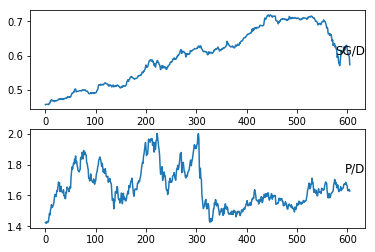

In [109]:
from matplotlib import pyplot
values = dataset.values
# specify columns to plot
groups = [8,9]
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

* Shift the currency exchange data by 1 week for prediction of target currency rate in the future week

In [110]:
dataset['next_week_SG/D'] = dataset['SG/D'].shift(-1)
dataset['next_week_P/D'] = dataset['P/D'].shift(-1)
# dataset.reset_index()

* Output dataset statistics

In [111]:
print dataset.describe().transpose()
print dataset.shape

                count          mean            std          min  \
DJI             606.0  3.870527e+03    1828.704100    1826.6300   
DJV             606.0  1.336914e+05   62182.252990   36121.4000   
S&P             606.0  4.752828e+02     210.575541     233.2800   
FTSE            606.0  2.936601e+03    1013.503926    1590.3000   
FTV             532.0  1.202328e+06  463723.001990  459913.0000   
STI             599.0  1.636933e+03     461.331329     728.3000   
STIV            505.0  5.858474e+05  545378.945184   45559.0000   
SG/D            606.0  5.978703e-01       0.080217       0.4558   
P/D             606.0  1.651239e+00       0.128119       1.4188   
SGPRIME         606.0  5.788779e+00       0.663965       4.7500   
UKPRIME         606.0  1.007838e+01       3.189964       6.2500   
USPRIME         606.0  8.337046e+00       1.434414       6.0000   
USINF           604.0  3.427599e+00       1.134551       1.1300   
UKINF           604.0  4.415397e+00       2.379553       1.220

* Fill NaN values with 0

In [112]:
print dataset.isnull().sum()
# dataset.fillna(0, inplace=True)
# dataset = dataset.fillna(dataset.mean(), inplace=True)
dataset.fillna(method='ffill', inplace=True)

DATE                0
DJI                 0
DJV                 0
S&P                 0
FTSE                0
FTV                74
STI                 7
STIV              101
SG/D                0
P/D                 0
SGPRIME             0
UKPRIME             0
USPRIME             0
USINF               2
UKINF               2
SGINF               6
YEAR                0
MONTH               0
DAY                 0
next_week_SG/D      1
next_week_P/D       1
dtype: int64


* Split the dataset into training and test sets to predict next week SG/D rate with a 1 week window
* The period of prediction is over the trading period of 3rd April 1996 to 1st April 1998

In [113]:
from sklearn.model_selection import train_test_split
train_set = dataset[(dataset['YEAR'] <= 1996) & (dataset['MONTH'] < 4)].drop('DATE',axis=1)
test_set = dataset[(dataset['YEAR'] >= 1996) & (dataset['MONTH'] > 4)].drop('DATE',axis=1)
y_train = train_set['next_week_SG/D']
X_train = train_set.drop('next_week_SG/D',axis=1)
y_test = test_set['next_week_SG/D']
X_test = test_set.drop('next_week_SG/D',axis=1)



* StandardScale the data

In [114]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)
# Now apply the transformations to the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

* Build a Neural Network model using taining data and test the model prediction

In [115]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp = MLPRegressor(hidden_layer_sizes=(13,13,13),max_iter=5000)
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print "MEAN SQAURE ERROR : ", mean_squared_error(y_test, predictions)

MEAN SQAURE ERROR :  0.0425864139462


* Export predictions for future week SG/D to csv

In [116]:
test_set['predicted_SG/D'] = predictions
print test_set.head(10)
test_set.to_csv('predictions.csv')

         DJI       DJV     S&P    FTSE        FTV      STI      STIV    SG/D  \
495  5575.22  163957.1  654.58  3806.0  1661802.0  2415.66  674687.0  0.7110   
496  5474.06  197585.6  644.77  3707.3  1661802.0  2371.83  599867.0  0.7116   
497  5625.44  177015.3  665.42  3776.2  1709172.0  2321.50  555917.0  0.7100   
498  5778.00  199696.8  678.42  3764.2  1871524.0  2313.02  481110.0  0.7096   
499  5673.83  134018.0  667.93  3775.7  1871524.0  2334.42  609086.0  0.7082   
500  5697.48  145799.1  678.44  3753.4  1871524.0  2326.81  609086.0  0.7095   
501  5668.29  162635.2  669.04  3769.2  1508992.0  2289.24  376715.0  0.7096   
502  5648.35  136945.1  661.96  3753.2  1841379.0  2291.93  328615.0  0.7106   
503  5682.70  198143.2  664.39  3695.5  1647262.0  2284.96  319165.0  0.7086   
504  5703.02  154308.4  672.40  3714.1  1549219.0  2271.56  469753.0  0.7076   

        P/D  SGPRIME       ...        USPRIME  USINF  UKINF  SGINF  YEAR  \
495  1.4925      6.0       ...           8.